In [129]:
import pandas as pd
import numpy as np
import seaborn as sns

In [130]:
df = pd.read_csv("Data_120294_2023-03-29.csv")


/tmp/ipykernel_86424/922264029.py:1: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data_120294_2023-03-29.csv")


## Choosing features
choosing which features should included in the model

In [131]:
#Choosing the columns that we want to use
features = ["init_age", "gender", "abo", 
                   "pramr", "prapk", "bmi_calc", 
                   "init_bmi_calc", "init_date", "tx_date", "hemo_pcw_tcr","hemo_pa_mn_tcr"]

features = df[features]

In [132]:
# Illustrate the data set of the chosen features with 15 random rows
features.sample(15)

,init_age,gender,abo,pramr,prapk,bmi_calc,init_bmi_calc,init_date,tx_date,hemo_pcw_tcr,hemo_pa_mn_tcr
31405,43.0,M,A,NaN,NaN,NaN,31.891314,17may2018,NaN,12.0,17.0
41497,0.0,M,O,NaN,NaN,NaN,NaN,09mar1990,NaN,NaN,NaN
24730,0.0,F,AB,NaN,NaN,NaN,13.200000,22dec2000,NaN,NaN,NaN
55569,60.0,M,B,0.0,0.0,22.191011,25.770105,11mar1997,04jul1997,28.0,44.0
37283,0.0,F,O,NaN,NaN,NaN,NaN,20oct1989,NaN,NaN,NaN
78049,36.0,M,O,0.0,0.0,27.411529,29.056221,02jan1991,08nov1991,NaN,NaN
109510,59.0,M,A,NaN,NaN,31.608871,35.425611,08nov2017,27jan2018,9.0,18.0
73309,47.0,F,O,57.0,57.0,24.657484,22.659320,06sep1995,22sep1996,9.0,14.0
48768,44.0,M,A,0.0,0.0,30.069575,30.069575,26sep1995,29nov1995,38.0,32.0
2010,22.0,M,A,NaN,NaN,NaN,22.175745,29may2014,NaN,9.0,15.0


In [133]:
#Display some basic info about the chosen features
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120264 entries, 0 to 120263
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   init_age        120257 non-null  float64
 1   gender          120264 non-null  object 
 2   abo             120264 non-null  object 
 3   pramr           32023 non-null   float64
 4   prapk           30295 non-null   float64
 5   bmi_calc        76538 non-null   float64
 6   init_bmi_calc   115418 non-null  float64
 7   init_date       120264 non-null  object 
 8   tx_date         77410 non-null   object 
 9   hemo_pcw_tcr    80933 non-null   float64
 10  hemo_pa_mn_tcr  83439 non-null   float64
dtypes: float64(7), object(4)
memory usage: 10.1+ MB


## Data preprocessing and data analysis
### Handling of duplicate values

In [ ]:
#Display information about the duplicates
features[features.duplicated()]

In [137]:
#Count number of duplicates
print("Number of duplicates: ", features.duplicated().sum())

#Number of duplicates before dropping
print("Number of rows before dropping duplicates: ", features.shape[0])
#Drop duplicates and keep the first occurence
features = features.drop_duplicates()

#Number of duplicates after dropping
print("Number of rows after dropping duplicates: ", features.shape[0])

Number of duplicates:  0
Empty DataFrame
Columns: [init_age, gender, abo, pramr, prapk, bmi_calc, init_bmi_calc, init_date, tx_date, hemo_pcw_tcr, hemo_pa_mn_tcr]
Index: []
Number of rows before dropping duplicates:  120187
Number of rows after dropping duplicates:  120187


## Cleaning
- Remove patients that died in waiting list

In [75]:
print("Patients pre-cleaning: ", df.shape[0])
print("Deaths in waiting list: ", df['death_date'].notnull().sum())

# tx_date: print unique values, amount of nulls, and amount of non-nulls
print("cocaine",df['hist_cocaine_don'].value_counts())
print("alcohol",df['alcohol_heavy_don'].value_counts())


# Drop all patients with death date
# df = df.drop(df[df['death_date'].notnull()].index)      #   WL DATE OF DEATH/POST 10/25/99 REMOVALS
df = df.drop(df[df['cod_wl'].notnull()].index)          #   WL Candidate Cause of Death for Death Removal
df = df.drop(df[df['cod_ostxt_wl'].notnull()].index)    #   WL Candidate Cause of Death for Death Removal, Other Specified

# drop all patients that don't have a valid tx_date or not in format %d%b%Y'
df = df.drop(df[df['tx_date'].isnull()].index)
df = df.drop(df[df['tx_date'].str.len() != 9].index)


# print abo unique values
# print(df['abo'].unique())
print("Patients post-cleaning: ", df.shape[0])

Patients pre-cleaning:  120264
Deaths in waiting list:  8648
cocaine N    43402
U    25789
Y     7900
Name: hist_cocaine_don, dtype: int64
alcohol N    35570
Y     5896
U      702
Name: alcohol_heavy_don, dtype: int64
Patients post-cleaning:  77410


## Transforming
- Drop redundant columns

patients:  77410
patients:  51738
       init_age gender abo  pramr  prapk   bmi_calc  init_bmi_calc  \
42855      54.0      M   O    0.0    0.0  29.270638      29.270701   
42856      10.0      M   A   10.0    0.0  17.954611      18.313703   
42857      55.0      M   O    0.0    0.0  25.325987      25.070862   
42859      43.0      M   O   20.0   25.0  18.363322      18.363322   
42860      48.0      M   O    3.0    3.0  25.327720      24.649885   

       hemo_pcw_tcr  hemo_pa_mn_tcr  wl_time  
42855          18.0            23.0       29  
42856          13.0            18.0        8  
42857          27.0            33.0       83  
42859           7.0            12.0       61  
42860          10.0            18.0       76  


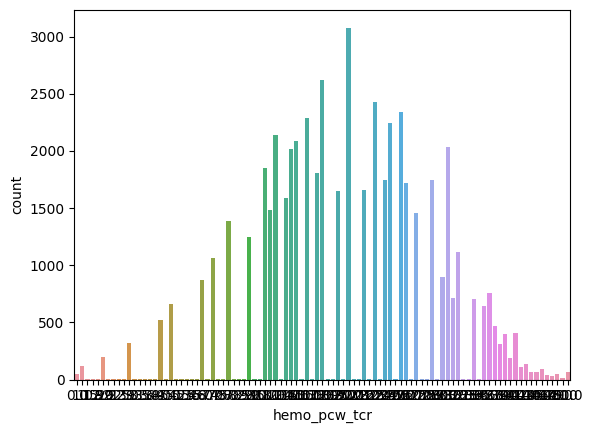

In [76]:
desired_columns = ["init_age", "gender", "abo", 
                   "pramr", "prapk", "bmi_calc", 
                   "init_bmi_calc", "init_date", "tx_date", "hemo_pcw_tcr","hemo_pa_mn_tcr"]

print("patients: ", df.shape[0])
#visualize value counts for hemo_pcw_tcr and hemop_pa_mn_tcr with seaborn
sns.countplot(x='hemo_pcw_tcr', data=df)


df['prapk'] = df['prapk'].fillna(df['prapk'].value_counts().idxmax())
df['pramr'] = df['pramr'].fillna(df['pramr'].value_counts().idxmax())

df = df[desired_columns]

df['wl_time'] = (pd.to_datetime(df['tx_date'], format='%d%b%Y') - pd.to_datetime(df['init_date'], format='%d%b%Y')).dt.days

# drop init_date and end_date
df = df.drop(['init_date', 'tx_date'], axis=1)

# remove any rows with NaN or Inf values
df = df.dropna()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print("patients: ", df.shape[0])
print(df.head())

## Encode

In [77]:
# encode categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

le = LabelEncoder() 
df["abo"] = le.fit_transform(df["abo"])
df["gender"] = le.fit_transform(df["gender"])
#df["alcohol_heavy_don"] = le.fit_transform(df["alcohol_heavy_don"])
# we want to predict if it took more or less than 60 days to get a transplant

df['wl_time'] = df['wl_time'].apply(lambda x: 1 if x > 30*6 else 0)

#for col in df.columns:
#    if df[col].dtype == 'object':
#        df[col] = le.fit_transform(df[col])


columns = ["init_age", "init_bmi_calc", "bmi_calc", "pramr", "prapk", "hemo_pcw_tcr", "hemo_pa_mn_tcr"]
scaler = StandardScaler()
df[columns] = scaler.fit_transform(df[columns])


## Build model

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Conv1D, LSTM, Flatten
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(df.drop('wl_time', axis=1), df['wl_time'], test_size=0.2, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))

model = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear'),
])


# compile the model
#model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

y_pred = model.predict(X_test)



Logistic Regression Accuracy:  0.6867993815229996
Epoch 1/30
1294/1294 [==============================] - 4s 3ms/step - loss: 1.6437 - accuracy: 0.6321
Epoch 2/30
1294/1294 [==============================] - 4s 3ms/step - loss: 1.1231 - accuracy: 0.6517
Epoch 3/30
1294/1294 [==============================] - 5s 4ms/step - loss: 0.6414 - accuracy: 0.6764
Epoch 4/30
1294/1294 [==============================] - 4s 3ms/step - loss: 0.6499 - accuracy: 0.6813
Epoch 5/30
 360/1294 [=======>......................] - ETA: 3s - loss: 0.6596 - accuracy: 0.6812

KeyboardInterrupt: 